# Setup

In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2


In [2]:
# %cd /home/aure/Documents/GitHub/GenSBI
%cd /lhome/ific/a/aamerio/github/GenSBI

/lhome/ific/a/aamerio/github/GenSBI


In [3]:
experiment_id = 1

In [4]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"

In [5]:
restore_model=True
train_model=False

In [6]:
import sys 
import os 
import pathlib
# get the directory of the current notebook
# fdir = pathlib.Path().parent.resolve()
# this file is located at /home/aure/Documents/GitHub/GenSBI/examples/sbi-benchmarks/two_moons/two_moons_jflux.ipynb, the root directory is GenSBI, how do I get there?
root = os.getcwd()# pwd
sys.path.append(f"{root}/examples/sbi-benchmarks")
sys.path.append(f"{root}/src")

In [7]:
%pwd

'/lhome/ific/a/aamerio/github/GenSBI'

In [8]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = f"{root}/examples/sbi-benchmarks/two_moons"
checkpoint_dir = f"{notebook_path}/checkpoints/two_moons_jflux_test"

os.makedirs(checkpoint_dir, exist_ok=True)

In [9]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx
import optax
from optax.contrib import reduce_on_plateau

from numpyro import distributions as dist

import grain.python as grain

from corner import corner

import numpy as np

from tqdm import tqdm

from functools import partial


/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
dtype = jnp.bfloat16

In [11]:
PATIENCE = 20  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100
# max LR
MAX_LR = 0.5e-3  # @param{type:"number"}
# Min scale for the learning rate:
MIN_LR = 0  # @param{type:"number"}
MIN_SCALE = MIN_LR / MAX_LR  # @param{type:"number"}

In [12]:
from sbi_utils.sbi_tasks import TwoMoons

from gensbi.flow_matching.path.scheduler import CondOTScheduler
from gensbi.flow_matching.path import AffineProbPath
from gensbi.flow_matching.solver import ODESolver

define the task

In [13]:
twomoons = TwoMoons()
task = twomoons.task
prior = twomoons.get_prior()
simulator = twomoons.get_simulator()

In [14]:
@partial(jax.jit, static_argnames=["size"])
def sample_prior(size):
    return jnp.array(prior.sample((size,)))

In [15]:
reference_samples = task.get_reference_posterior_samples(num_observation=8)

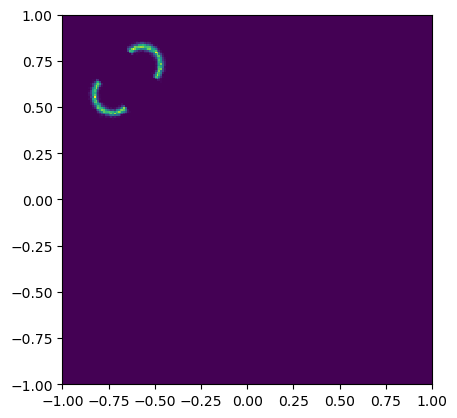

In [16]:
plt.hist2d(reference_samples[:, 0], reference_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# dataset

In [17]:
# make a dataset
nsamples = int(1e6)
val_size = 512
theta = prior.sample((nsamples+val_size,))
xs = jnp.array(simulator(theta))
node_ids = jnp.array(twomoons.get_node_id())
dim_theta = twomoons.get_theta_dim()
dim_x = twomoons.get_x_dim()

# turn them into jax arrays
theta = jnp.array(theta)
xs = jnp.array(xs)

# concatenate the data, theta and xs
data = jnp.concatenate((theta, xs), axis=-1)


train_data = jnp.asarray(data[:nsamples], dtype=dtype)
val_data = jnp.asarray(data[nsamples:], dtype=dtype)


In [18]:
cond_ids = jnp.arange(dim_theta, dtype=jnp.int32).reshape(1,-1,1)
obs_ids = jnp.arange(dim_x, dtype=jnp.int32).reshape(1,-1,1)

In [19]:
batch_size = 8*1024 # the model greatly benefits from larger batch sizes to avoid overfitting, but this is limited by the GPU memory
# dataset = InfiniteDataLoader(train_data, batch_size, rng=nnx.Rngs(0).dataset())

In [20]:
dataset_grain = (
    grain.MapDataset.source(np.array(train_data))
    .shuffle(42)
    .repeat()
    .to_iter_dataset(grain.ReadOptions(num_threads=16, prefetch_buffer_size=batch_size*5))
    .batch(batch_size=batch_size)  # Batches consecutive elements.
)

val_dataset_grain = (
    grain.MapDataset.source(np.array(val_data))
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(batch_size=512)  # Batches consecutive elements.
)

In [21]:
dataset_iter = iter(dataset_grain)
val_dataset_iter = iter(val_dataset_grain)

## utils

In [62]:
from gensbi.utils.model_wrapping import ModelWrapper, GuidedModelWrapper
from einops import rearrange

class FluxWrapper(ModelWrapper):
    def __init__(self, model, conditioned=True):
        super().__init__(model)
        self.conditioned = conditioned

    def _call_model(self, x, t, args, **kwargs):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')

        return jnp.squeeze(self.model(obs=x, timesteps=t, conditioned=self.conditioned, **kwargs), axis=-1)

class GuidedFluxWrapper(GuidedModelWrapper):
    def __init__(self, model, cfg_scale):
        super().__init__(model, cfg_scale)

    def _call_model(self, x, t, args, **kwargs):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')

        return jnp.squeeze(self.model(obs=x, timesteps=t, **kwargs), axis=-1)
    

def get_samples(vf_wrapped, idx, nsamples=10_000, seed=42):
    observation =  jnp.array(twomoons.get_observation(idx), dtype=dtype) 
    true_param = jnp.array(task.get_true_parameters(idx), dtype=dtype)
    reference_samples = task.get_reference_posterior_samples(num_observation=idx)

    rng = jax.random.PRNGKey(seed)

    step_size = 0.01

    rng, key1 = jax.random.split(rng, 2)

    x_init = jax.random.normal(key1,(nsamples, dim_theta), dtype=dtype) # n, T_max, 1
    cond = jnp.broadcast_to(observation[...,None], (nsamples, dim_x, 1)) # n, dim_theta, 1

    solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
    model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

    sampler_ = solver.get_sampler(method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
    samples = sampler_(x_init)  # sample from the model

    return samples, true_param, reference_samples

def plot_samples(samples, true_param):
    plt.hist2d(samples[:,0], samples[:,1], bins=200, range=[(-1, 1), (-1, 1)], density=True)
    # same ratio on axis 
    plt.scatter(true_param[0,0], true_param[0,1], s=100, color='red', alpha=0.5, marker='x')
    # plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.show()

    corner(np.array(samples), bins=100, range=[(-1, 1), (-1, 1)], smooth=True, fill_contours=True)
    plt.show()
    return

# define the CFM model

In [23]:
from gensbi.models import FluxParams, Flux, FluxCFMLoss

In [24]:
path = AffineProbPath(scheduler=CondOTScheduler()) # define the probability path

In [25]:
params=FluxParams(
            in_channels=1,
            vec_in_dim=None,
            context_in_dim=1,
            mlp_ratio=4,
            qkv_multiplier=1,
            num_heads=4,
            depth=12,
            depth_single_blocks=24,
            axes_dim=[6,],
            use_rope = True,
            theta = 20,
            obs_dim = 2,
            cond_dim = 2,
            qkv_bias=True,
            guidance_embed=False,
            rngs=nnx.Rngs(default=42),
            param_dtype=jnp.bfloat16,
        ) # experiment 1

# params=FluxParams(
#             in_channels=1,
#             vec_in_dim=None,
#             context_in_dim=1,
#             mlp_ratio=4,
#             qkv_multiplier=1,
#             num_heads=4,
#             depth=2,
#             depth_single_blocks=4,
#             axes_dim=[10,],
#             use_rope = True,
#             theta = 20,
#             obs_dim = 2,
#             cond_dim = 2,
#             qkv_bias=True,
#             guidance_embed=False,
#             rngs=nnx.Rngs(default=42),
#             param_dtype=dtype,
#         ) # experiment 2

In [26]:
loss_fn_cfm = FluxCFMLoss(path)

In [27]:
p0_dist_model = dist.Independent(
    dist.Normal(loc=jnp.zeros((2,)), scale=jnp.ones((2,))),
    reinterpreted_batch_ndims=1
)

In [28]:
def loss_fn_(vf_model, batch, key: jax.random.PRNGKey):

    obs = batch[:,:2][...,None]
    cond = batch[:,2:][...,None]

    key1, key2 = jax.random.split(key, 2)

    x_1 = obs
    x_0 = jax.random.normal(key1, x_1.shape, dtype=dtype)
    t = jax.random.uniform(key2, x_1.shape[0], dtype=dtype)
    
    batch = (x_0, x_1, t)

    loss=loss_fn_cfm(vf_model, batch, cond, obs_ids, cond_ids)
    return loss

In [29]:
@nnx.jit
def train_loss(vf_model, key: jax.random.PRNGKey):
    batch = next(dataset_iter) # n, T_max, 1
    return loss_fn_(vf_model, batch, key)

In [30]:
@nnx.jit
def val_loss(vf_model, key):
    batch = next(val_dataset_iter)
    return loss_fn_(vf_model, batch, key)

In [31]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: train_loss(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads, value=loss)  # In place updates.
    return loss

In [32]:
vf_model = Flux(params)

In [33]:
# restore the model
if restore_model:
    model_state = nnx.state(vf_model)
    graphdef, abstract_state = nnx.split(vf_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            experiment_id,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )

    vf_model= nnx.merge(graphdef, restored["state"])
    print("Restored model from checkpoint")

ERROR:absl:File /lhome/ific/a/aamerio/github/GenSBI/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_jflux_test/3/metrics/metrics not found.
ERROR:absl:File /lhome/ific/a/aamerio/github/GenSBI/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_jflux_test/1/metrics/metrics not found.
ERROR:absl:File /lhome/ific/a/aamerio/github/GenSBI/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_jflux_test/2/metrics/metrics not found.
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restored model from checkpoint


In [34]:
# # linear learning rate schedule
# nsteps = 10_000 
# nepochs = 5


# schedule = optax.schedules.linear_schedule(1e-3, 1e-6, 40000, 10000)

# opt = optax.chain(optax.adaptive_grad_clip(10.0), optax.adamw(schedule))

# # opt = optax.MultiSteps(opt, 2)

# optimizer = nnx.Optimizer(vf_model, opt)

In [35]:
# reduce on plateau schedule
nsteps = 10_000
nepochs = 3

multistep = 1 # if the GPU cannot support batch sizes of at least 4k, adjust this value accordingly to get the desired effective batch size

# warmup_schedule = optax.schedules.warmup_constant_schedule(1e-5, MAX_LR, warmup_steps=1000)

opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    # optax.adamw(warmup_schedule),
    optax.adamw(MAX_LR),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)
if multistep > 1:
    opt = optax.MultiSteps(opt, multistep)
optimizer = nnx.Optimizer(vf_model, opt)

In [36]:
rngs = nnx.Rngs(0)

In [37]:
best_state = nnx.state(vf_model)
last_state = nnx.state(vf_model)
last_viable_state = nnx.state(vf_model)
best_val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
validate_every = 100

loss_array = []
val_loss_array = []

early_stopping = True

In [38]:
flag=True
if train_model:
    vf_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        v_l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                if flag:
                    print("Early stopping")
                    last_state = nnx.state(vf_model)

                    print("Latest Iteration")
                    idx = 8
                    vf_wrapped = FluxWrapper(vf_model)
                    samples, true_param, reference_samples = get_samples(vf_wrapped, idx)
                    plot_samples(samples, true_param)
                    
                    
                    # restore the model state
                    print("last viable state")
                    graphdef, abstract_state = nnx.split(vf_model)
                    vf_model = nnx.merge(graphdef, last_viable_state)
                    idx = 8
                    vf_wrapped = FluxWrapper(vf_model)
                    samples, true_param, reference_samples = get_samples(vf_wrapped, idx)
                    plot_samples(samples, true_param)


                    print("best val loss state")
                    graphdef, abstract_state = nnx.split(vf_model)

                    vf_model = nnx.merge(graphdef, best_state)

                    idx = 8
                    vf_wrapped = FluxWrapper(vf_model)
                    samples, true_param, reference_samples = get_samples(vf_wrapped, idx)
                    plot_samples(samples, true_param)

                    flag=False


                break

            loss = train_step(vf_model, optimizer, rngs.train_step())
            l += loss.item()
            
            v_loss = val_loss(vf_model, rngs.val_step())
            v_l += v_loss.item()

            if j > 0 and j % validate_every == 0:
                loss_ = l / validate_every
                val_ = v_l / validate_every

                ratio1 = val_ / loss_
                ratio2 = val_ / best_val_loss_value

                # if ratio1 < val_error_ratio and ratio2 < 1.05:
                if ratio1 < val_error_ratio:
                    last_viable_state = nnx.state(vf_model)
                    if val_ < best_val_loss_value:
                        best_val_loss_value = val_
                        best_state = nnx.state(vf_model)
                    elif ratio2 < 1.08:
                        best_state = nnx.state(vf_model) # still update the best state if the ratio is below 1.08

                    counter = 0
                else:
                    counter += 1

                # scale = tree_get(optimizer.opt_state, "ReduceLROnPlateauState").scale.value
                # pbar.set_postfix(loss=f"{l/(100):.4f}", ratio=f"{ratio:.4f}", counter=counter, lr_scale=scale, val_loss = f"{val_:.4f}" )
                pbar.set_postfix(
                    loss=f"{loss_:.4f}",
                    ratio=f"{ratio1:.4f}",
                    counter=counter,
                    val_loss=f"{val_:.4f}",
                )
                loss_array.append(loss_)
                val_loss_array.append(val_)
                l = 0
                v_l = 0

            if j>0 and j%3000 == 0:
                idx = 8
                vf_wrapped = FluxWrapper(vf_model)
                samples, true_param, reference_samples = get_samples(vf_wrapped, idx)
                plot_samples(samples, true_param)
        # print(l)

    vf_model.eval()

In [39]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=10,
            keep_checkpoints_without_metrics=True,
            create=True,
        ),
    )
    model_state = nnx.state(vf_model)
    checkpoint_manager.save(
        experiment_id, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()

In [40]:
if train_model:
    plt.plot(loss_array, label="train loss")
    plt.plot(val_loss_array, label="val loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

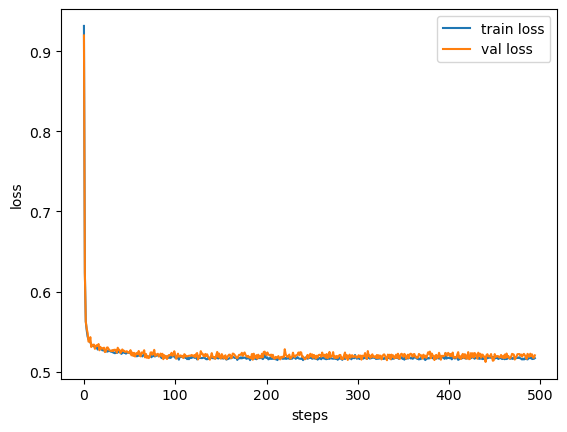

# sample the posterior

## plotting

In [41]:
idx = 8
vf_wrapped = FluxWrapper(vf_model)
samples, true_param, reference_samples = get_samples(vf_wrapped, idx, 100_000)

In [42]:
posterior_samples = samples

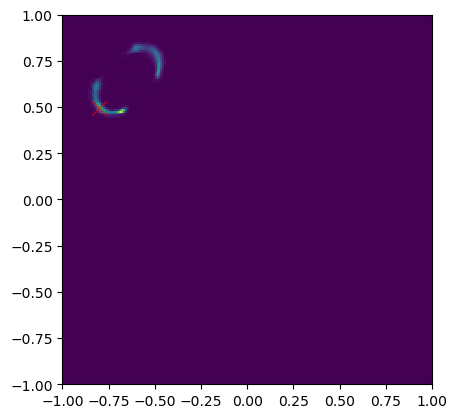

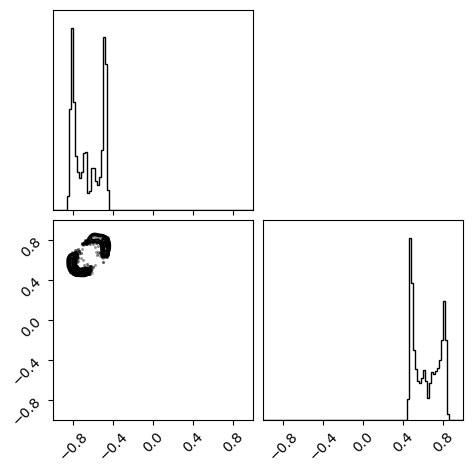

In [43]:
plot_samples(posterior_samples, true_param)

19 36 4 1e6, checkpoint 2, 0.62 c2st <br> 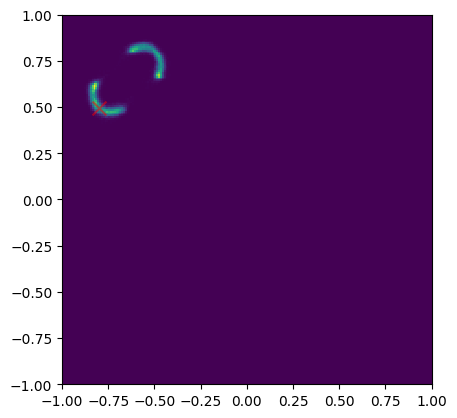

14 28 4 1e6, checkpoint 1, 0.54 c2st <br> 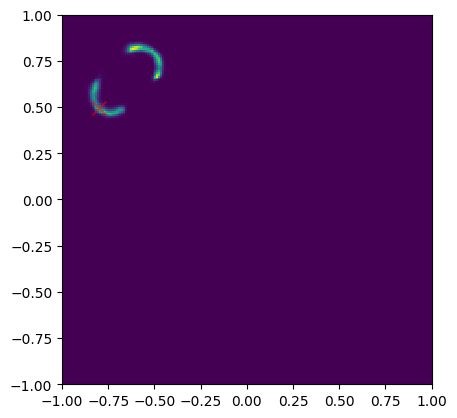

10 20 4 1e6 <br>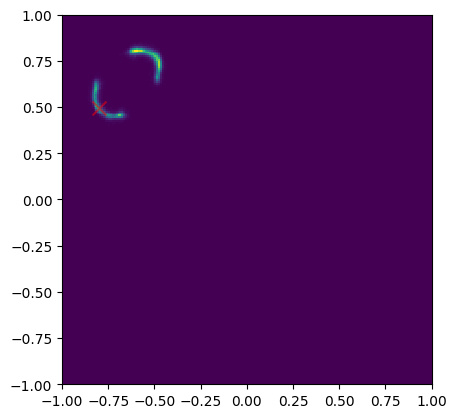

6 12 20 1e6 <br> 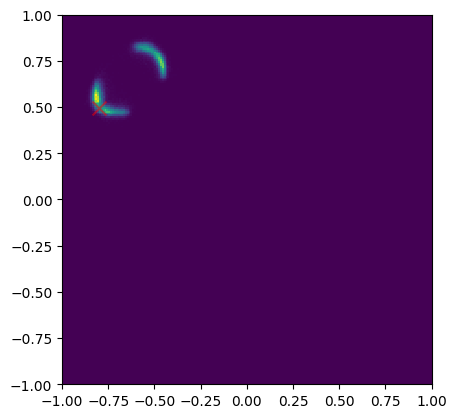

4 8 20 <br> 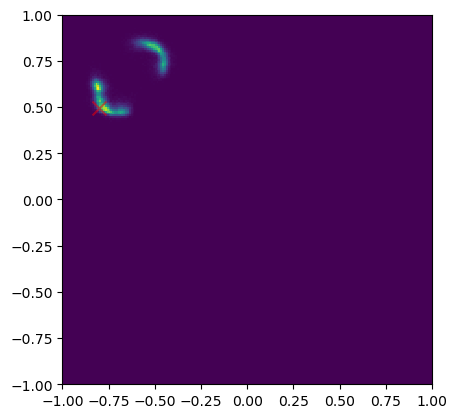

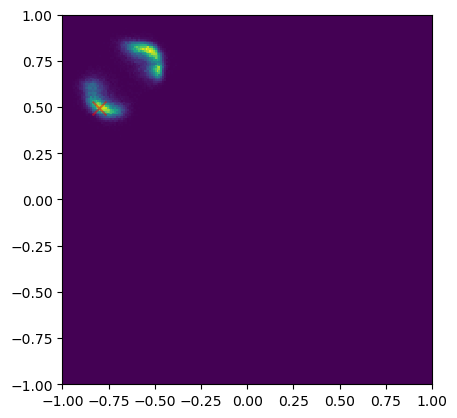

/tmp/ipykernel_159311/1071246627.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])


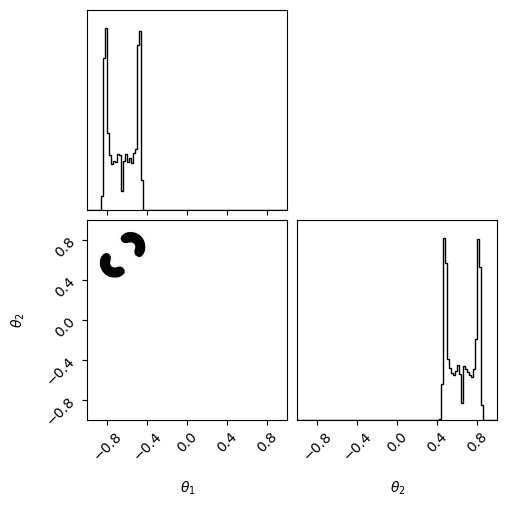

In [44]:
corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

In [45]:
# raise ValueError("Stop here, the model is trained and the samples are generated. You can now use the model to generate samples.")

# evaluate the posterior

In [46]:
# idx = 8
# observation = jnp.array(twomoons.get_observation(idx))
# solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class

In [47]:
# p0_cond = dist.Independent(
#     dist.Normal(loc=jnp.zeros((2,)), scale=jnp.ones((2,))),
#     reinterpreted_batch_ndims=1
# )

In [48]:
# grid_size = 200
# x_1 = jnp.meshgrid(jnp.linspace(-1, 1, grid_size), jnp.linspace(-1, 1, grid_size))
# x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

# # cond = jnp.broadcast_to(observation[...,None], (x_1.shape[0], dim_theta,1)) # n, dim_theta, 1
# # cond = jnp.broadcast_to(observation, (x_1.shape[0], dim_theta)) # n, dim_theta, 1
# cond = jnp.broadcast_to(observation[...,None], (1, dim_theta,1)) # n, dim_theta, 1

# obs_ids = jnp.array([0, 1])
# cond_ids = jnp.array([2, 3])
# model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

In [49]:
# # get the logprob
# # logp_sampler = solver.get_unnormalized_logprob(condition_mask=condition_mask, time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_dist_model.log_prob, model_extras=model_extras)
# logp_sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0],method='Dopri5', step_size=0.01, log_p0=p0_cond.log_prob, model_extras=model_extras)
# # create an y_init which has theta on the first position and x1,x2 on the second and third position

# # y_init = p0_cond.sample(jax.random.PRNGKey(0), (x_1.shape[0],))  # n, dim_theta
# y_init = x_1

# exact_log_p = logp_sampler(y_init)
# p = jnp.exp(exact_log_p)[-1]


In [50]:
# p_grid = p.reshape((grid_size, grid_size))
# plt.imshow(p_grid, origin='lower', aspect='auto', extent=(-1, 1, -1, 1), cmap='viridis')
# plt.xlim((-1,1))
# plt.ylim((-1,1))
# plt.colorbar()
# plt.show()

# sample with guidance

In [51]:
# gvf_wrapped = GuidedFluxWrapper(vf_model, cfg_scale=0.95)

In [52]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
# idx=8

In [53]:
# samples = get_samples(gvf_wrapped, idx, nsamples=100_000)[0]

In [54]:
# posterior_samples = samples

# plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=100, range=[(-1, 1), (-1, 1)], density=True)
# # same ratio on axis 
# # plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
# plt.gca().set_aspect('equal', adjustable='box')
# # plt.xlim((-1,1))
# # plt.ylim((-1,1))
# plt.show()

In [55]:
# corner(np.array(posterior_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
# plt.show()

# C2ST test

In [56]:
from sbibm.metrics import c2st

In [57]:
# convert posterior samples to a torch array
import torch
idx = 1

In [58]:
# # last model
# graphdef, abstract_state = nnx.split(vf_model)
# vf_model = nnx.merge(graphdef, last_state)

# vf_wrapped = FluxWrapper(vf_model)
# samples, true_param, reference_samples = get_samples(vf_wrapped, idx,nsamples=reference_samples.shape[0])
# plot_samples(samples, true_param)
# posterior_samples_torch = torch.tensor(np.array(samples), dtype=torch.float32)

# c2st_accuracy = c2st(reference_samples, posterior_samples_torch)
# print("c2st: ", c2st_accuracy)

In [59]:
# # last viable model
# graphdef, abstract_state = nnx.split(vf_model)
# vf_model = nnx.merge(graphdef, last_viable_state)

# vf_wrapped = FluxWrapper(vf_model)
# samples, true_param, reference_samples = get_samples(vf_wrapped, idx,nsamples=reference_samples.shape[0])
# plot_samples(samples, true_param)
# posterior_samples_torch = torch.tensor(np.array(samples), dtype=torch.float32)

# c2st_accuracy = c2st(reference_samples, posterior_samples_torch)
# print("c2st: ", c2st_accuracy)

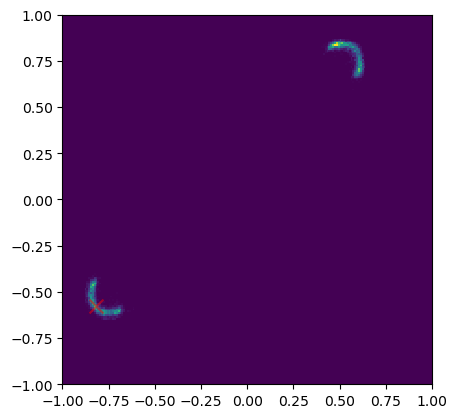

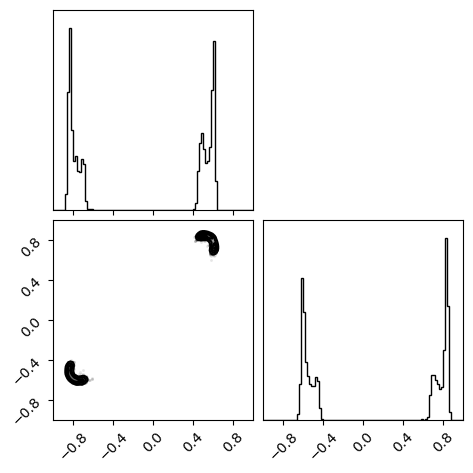

c2st:  tensor([0.5264])


In [60]:
# best val model
vf_wrapped = FluxWrapper(vf_model)
samples, true_param, reference_samples = get_samples(vf_wrapped, idx,nsamples=reference_samples.shape[0])
plot_samples(samples, true_param)
posterior_samples_torch = torch.tensor(np.array(samples), dtype=torch.float32)

c2st_accuracy = c2st(reference_samples, posterior_samples_torch)
print("c2st: ", c2st_accuracy)

In [66]:
train_loss(vf_model, jax.random.PRNGKey(0))

Array(0.32061848, dtype=float32)